In [1]:
import argparse
import os

from pathlib import Path

import torch
from torch.backends import cudnn

from tqdm import tqdm

from utils.checkpoint import save_checkpoint
from datasets.vessel_set import VesselSet, AneuriskVesselSet
from modules.edm import EDMLoss, EDMPrecond
import numpy as np
import matplotlib.pyplot as plt


/home/eiarussi/miniconda3/envs/vessel/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_set = VesselSet(split="train", path="dummy_data")

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=1,
    num_workers=0,
    drop_last=True,
    shuffle=False,
)

for i, (inputs, labels) in enumerate(train_loader):
    print("p", inputs.shape)

torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([256, 8])
p torch.Size([1, 256, 8])
torch.Size([2

In [3]:
files = os.listdir("centerlineArray")

In [4]:
all_vessels = []

for file in files:
    if file.endswith(".npy"):
        aneu = np.load("centerlineArray/" + file)
        segment_numbers = np.unique(aneu[:, -1])

        # Collect segments for this vessel
        segments = []
        for seg_num in segment_numbers:
            # Filter rows for the current segment and remove the segment number column
            segment_points = aneu[aneu[:, -1] == seg_num][:, :-1]
            segments.append(segment_points)
        
        # Find the maximum number of points in any segment for this vessel
        max_points = max(segment.shape[0] for segment in segments)

        # Pad each segment to have the same number of points
        padded_segments = [
            np.pad(segment, ((0, max_points - segment.shape[0]), (0, 0)), 'constant')
            for segment in segments
        ]

        # Stack all segments for this vessel along a new dimension (axis 0)
        vessel_data = np.stack([padded_segments], axis=0)
        
        # Add the stacked segments for this vessel to the list of all vessels
        all_vessels.append(vessel_data)

max_segments = max(arr.shape[1] for arr in all_vessels)
max_points = max(arr.shape[2] for arr in all_vessels)


print(all_vessels[0].shape)
print(all_vessels[1].shape)
# Pad each array to have the shape (1, max_segments, max_points, 4)
padded_arrays = []
for arr in all_vessels:
    # Calculate padding for the segments and points dimensions
    pad_segments = max_segments - arr.shape[1]
    pad_points = max_points - arr.shape[2]
    
    # Pad the array
    padded_arr = np.pad(
        arr,
        pad_width=((0, 0), (0, pad_segments), (0, pad_points), (0, 0)),
        mode='constant',
        constant_values=0  # You can change this if needed
    )
    padded_arrays.append(padded_arr)

# Stack the padded arrays along a new dimension
final_data = np.concatenate(padded_arrays, axis=0)

print("Final data shape:", final_data.shape)  # Expected shape: (number_of_arrays, max_segments, max_points, 4)
np.save("datasets/aneurisk/data_train.npy", final_data)

(1, 5, 953, 4)
(1, 5, 1215, 4)
Final data shape: (98, 12, 1615, 4)


In [5]:
'''
agrego one hot encoding con el numero de segmento. sirve para graficar pero no para entrenar
import numpy as np

all_vessels = []
max_segments = 12  # Assuming the maximum number of segments is 12

for file in files:
    if file.endswith(".npy"):
        aneu = np.load("centerlineArray/" + file)
        segment_numbers = np.unique(aneu[:, -1]).astype(int)  # Segment numbers (branch numbers) as integers

        # Collect segments for this vessel
        segments = []
        for seg_num in segment_numbers:
            # Filter rows for the current segment and remove the segment number column
            segment_points = aneu[aneu[:, -1] == seg_num][:, :-1]

            # Generate a one-hot encoding for the segment number
            one_hot = np.zeros((segment_points.shape[0], max_segments))
            one_hot[:, seg_num] = 1  # Set the one-hot encoding for this segment

            # Append one-hot encoding to the segment points
            segment_with_one_hot = np.concatenate([segment_points, one_hot], axis=1)
            segments.append(segment_with_one_hot)
        
        # Find the maximum number of points in any segment for this vessel
        max_points = max(segment.shape[0] for segment in segments)

        # Pad each segment to have the same number of points
        padded_segments = [
            np.pad(segment, ((0, max_points - segment.shape[0]), (0, 0)), 'constant')
            for segment in segments
        ]

        # Stack all segments for this vessel along a new dimension (axis 0)
        vessel_data = np.stack(padded_segments, axis=0)
        
        # Add the stacked segments for this vessel to the list of all vessels
        all_vessels.append(vessel_data)

# Determine the maximum segments and points across all vessels
max_segments = max(arr.shape[0] for arr in all_vessels)
max_points = max(arr.shape[1] for arr in all_vessels)

# Pad each array to have the shape (max_segments, max_points, 16)
padded_arrays = []
for arr in all_vessels:
    # Calculate padding for the segments and points dimensions
    pad_segments = max_segments - arr.shape[0]
    pad_points = max_points - arr.shape[1]
    
    # Pad the array
    padded_arr = np.pad(
        arr,
        pad_width=((0, pad_segments), (0, pad_points), (0, 0)),
        mode='constant',
        constant_values=0  # You can change this if needed
    )
    padded_arrays.append(padded_arr)

# Stack the padded arrays along a new dimension
final_data = np.stack(padded_arrays, axis=0)

print("Final data shape:", final_data.shape)  # Expected shape: (98, max_segments, max_points, 16)
np.save("datasets/aneurisk/data_train.npy", final_data)
'''

'\nagrego one hot encoding con el numero de segmento. sirve para graficar pero no para entrenar\nimport numpy as np\n\nall_vessels = []\nmax_segments = 12  # Assuming the maximum number of segments is 12\n\nfor file in files:\n    if file.endswith(".npy"):\n        aneu = np.load("centerlineArray/" + file)\n        segment_numbers = np.unique(aneu[:, -1]).astype(int)  # Segment numbers (branch numbers) as integers\n\n        # Collect segments for this vessel\n        segments = []\n        for seg_num in segment_numbers:\n            # Filter rows for the current segment and remove the segment number column\n            segment_points = aneu[aneu[:, -1] == seg_num][:, :-1]\n\n            # Generate a one-hot encoding for the segment number\n            one_hot = np.zeros((segment_points.shape[0], max_segments))\n            one_hot[:, seg_num] = 1  # Set the one-hot encoding for this segment\n\n            # Append one-hot encoding to the segment points\n            segment_with_one_h

(12, 1615, 4)


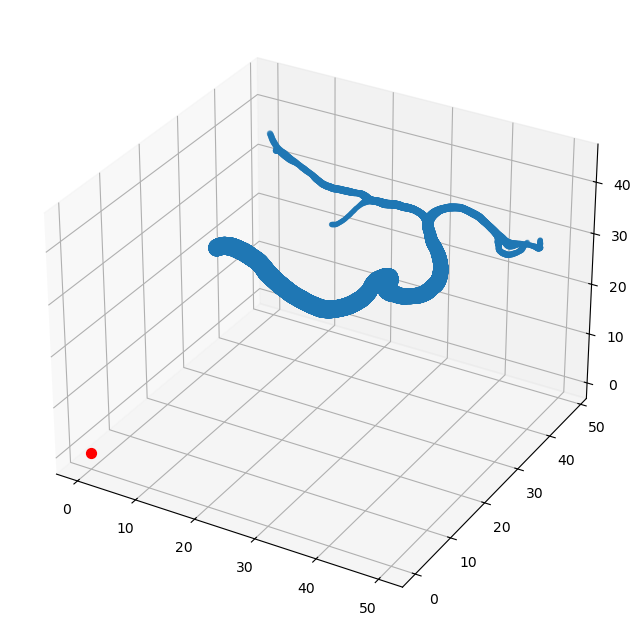

(12, 1615, 4)


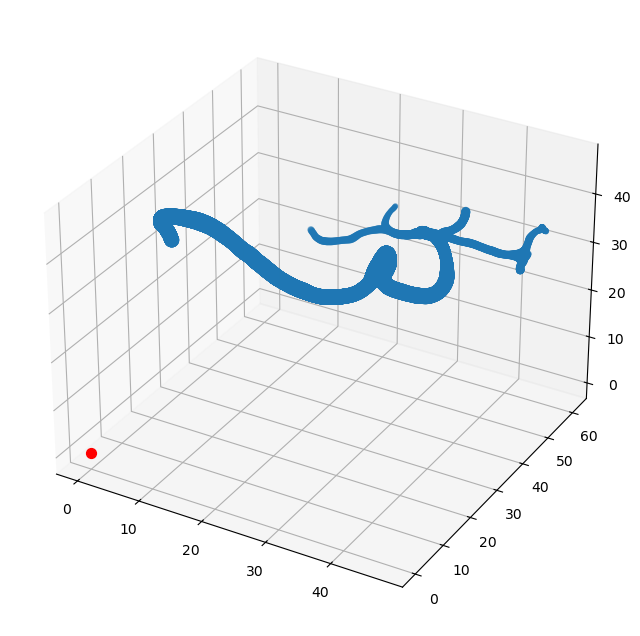

(12, 1615, 4)


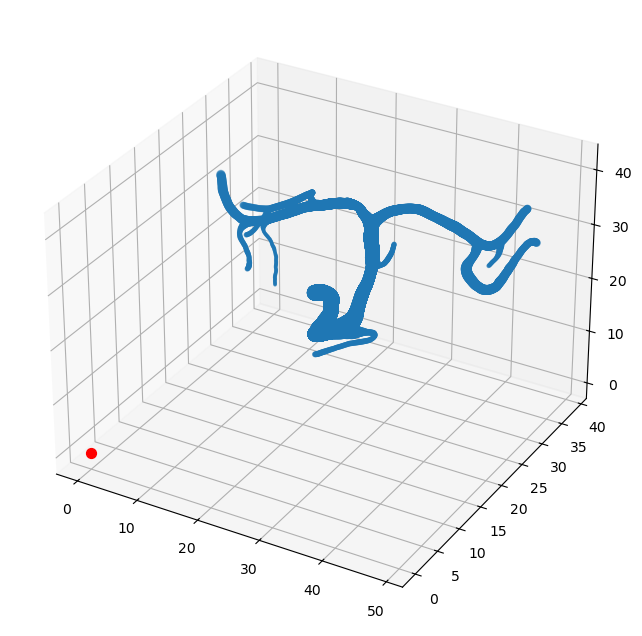

In [6]:
for i, inputs in enumerate(final_data):
    print(inputs.shape)
    points, radii, types = inputs[:, :, :3], inputs[:, :, 3], inputs[:, :, 4:]
    mask = ~(np.all(points == 0, axis=-1))  # Keep points that are not (0, 0, 0)
    # Filter out the padded points
    points = points[mask]
    radii = radii[mask]
    types = types[mask]
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(projection="3d")
    ax.scatter(*points.T, s=(5*radii)**2)
    ax.scatter(0, 0, 0, color='red', s=50)
    #ax.set_xlim(-1, 1)
    #ax.set_ylim(-1, 1)
    #ax.set_zlim(-1, 1)

    plt.show()
    if i > 1:
        break

In [7]:
train_set = AneuriskVesselSet(split="train", path="aneurisk")

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=1,
    num_workers=0,
    drop_last=True,
    shuffle=False,
)

In [8]:
vessel, label = next(iter(train_loader))
vessel.shape

IndexError: index 4 is out of bounds for axis 1 with size 4

len  5
segment (46, 4)
vessel_type 0
one hot (46, 5)
segment (56, 4)
vessel_type 1
one hot (56, 5)
segment (54, 4)
vessel_type 2
one hot (54, 5)
segment (50, 4)
vessel_type 3
one hot (50, 5)
segment (50, 4)
vessel_type 4
one hot (50, 5)
p torch.Size([1, 256, 9])


/tmp/ipykernel_3465561/3663490946.py:9: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1720538437738/work/aten/src/ATen/native/TensorShape.cpp:3697.)
  ax.scatter(*points.T, s=(100 * radii) ** 2, c=types.argmax(-1), vmin=0, vmax=3)


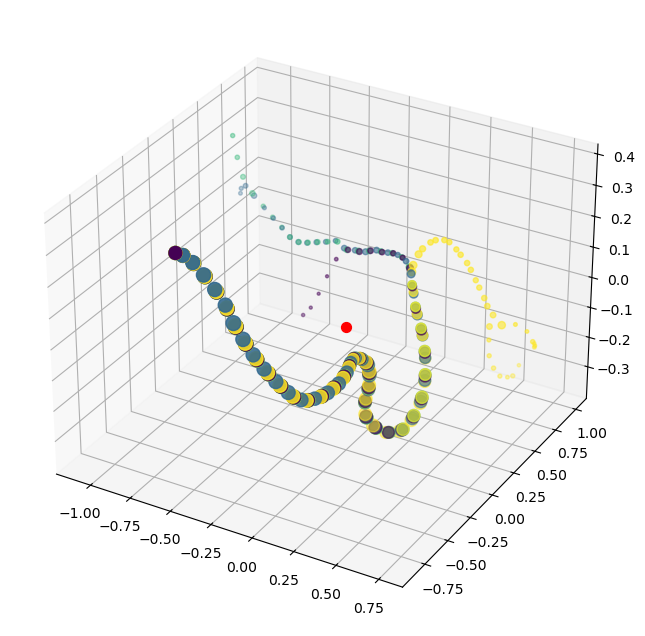

len  5
segment (43, 4)
vessel_type 0
one hot (43, 5)
segment (47, 4)
vessel_type 1
one hot (47, 5)
segment (52, 4)
vessel_type 2
one hot (52, 5)
segment (60, 4)
vessel_type 3
one hot (60, 5)
segment (54, 4)
vessel_type 4
one hot (54, 5)
p torch.Size([1, 256, 9])


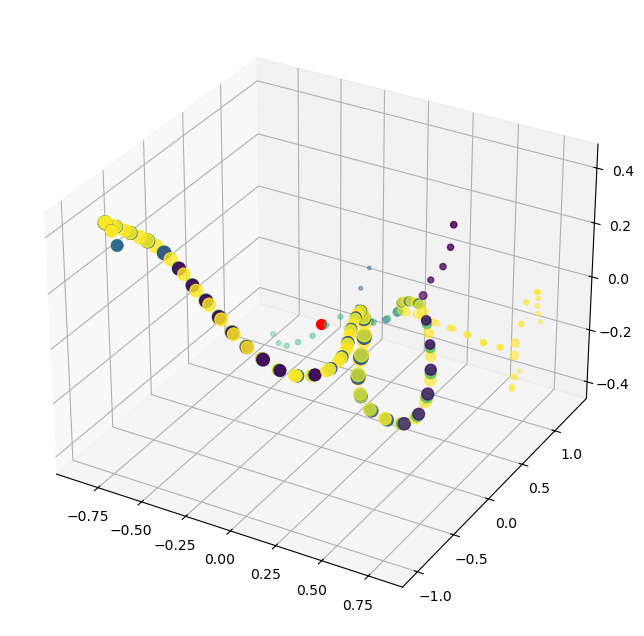

len  10
segment (14, 4)
vessel_type 0
one hot (14, 5)
segment (16, 4)
vessel_type 1
one hot (16, 5)
segment (39, 4)
vessel_type 2
one hot (39, 5)
segment (28, 4)
vessel_type 3
one hot (28, 5)
segment (25, 4)
vessel_type 4
one hot (25, 5)
segment (27, 4)
vessel_type 5
one hot (27, 5)


IndexError: index 5 is out of bounds for axis 1 with size 5

In [ ]:
for i, (inputs, labels) in enumerate(train_loader):
    print("p", inputs.shape)

    points, radii, types = inputs[:, :, :3], inputs[:, :, 3], inputs[:, :, 4:]
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(projection="3d")
    #ax.scatter(*points.T, s=(220 * radii) ** 2, c=types.argmax(-1), vmin=0, vmax=3)
    ax.scatter(*points.T, s=(100 * radii) ** 2, c=types.argmax(-1), vmin=0, vmax=3)
    ax.scatter(0, 0, 0, color='red', s=50, label="Origin")
    
    #ax.set_xlim(-1, 1)
    #ax.set_ylim(-1, 1)
    #ax.set_zlim(-1, 1)

    plt.show()
    if i > 4:
        break

In [ ]:
import matplotlib.pyplot as plt

Ahora genero los datos cortando todos los arboles a maximo 4 segmentos

In [11]:
import numpy as np
import os

all_vessels = []
max_segments = 4  # Only keep the first four segments

for file in files:
    if file.endswith(".npy"):
        aneu = np.load(os.path.join("centerlineArray", file))
        segment_numbers = np.unique(aneu[:, -1]).astype(int)  # Segment numbers (branch numbers) as integers

        # Collect segments for this vessel
        segments = []
        for seg_num in segment_numbers:
            if seg_num >= max_segments:
                #print(f"Warning: Segment number {seg_num} exceeds max_segments ({max_segments - 1}). Skipping this segment.")
                continue  # Skip this segment if it exceeds the max_segments

            # Filter rows for the current segment and remove the segment number column
            segment_points = aneu[aneu[:, -1] == seg_num][:, :-1]

            
            segments.append(segment_points)

        # Keep only the first four segments (or all segments if fewer than 4)
        segments = segments[:max_segments]
        

        # Find the maximum number of points in any segment for this vessel
        max_points = max(segment.shape[0] for segment in segments)

        # If fewer than 4 segments are available, pad with zeros
        while len(segments) < max_segments:
            segments.append(np.zeros((max_points, 4)))  # Assuming each segment has the same number of features

        # Pad each segment to have the same number of points
        padded_segments = [
            np.pad(segment, ((0, max_points - segment.shape[0]), (0, 0)), 'constant')
            for segment in segments
        ]
        
        
        # Stack all segments for this vessel along a new dimension (axis 0)
        vessel_data = np.stack([padded_segments], axis=0)

        # Add the stacked segments for this vessel to the list of all vessels
        all_vessels.append(vessel_data)

# Determine the maximum points across all vessels

max_points = max(arr.shape[2] for arr in all_vessels)
# Pad each array to have the shape (max_segments, max_points, 16)
padded_arrays = []
for arr in all_vessels:
    # Calculate padding for the points dimension
    pad_points = max_points - arr.shape[2]
    # Pad the array
    padded_arr = np.pad(
        arr,
        pad_width=((0, 0), (0, 0), (0, pad_points), (0, 0)),
        mode='constant',
        constant_values=0  # Padding value can be adjusted if necessary
    )
    padded_arrays.append(padded_arr)
    


# Stack the padded arrays along a new dimension
final_data = np.stack(padded_arrays, axis=0)

final_data = final_data.reshape(98,4,1615,4)
print("Final data shape:", final_data.shape)  # Expected shape: (num_vessels, max_segments, max_points, 16)

train = final_data[:90,:,:,:]
test =  final_data[90:,:,:,:]
np.save("datasets/aneurisk/data_train.npy", train)
np.save("datasets/aneurisk/data_test.npy", test)

Final data shape: (98, 4, 1615, 4)


In [ ]:
a = np.load("datasets/aneurisk/data_train.npy")
a.shape

(98, 4, 1615, 4)

p torch.Size([1, 256, 8])


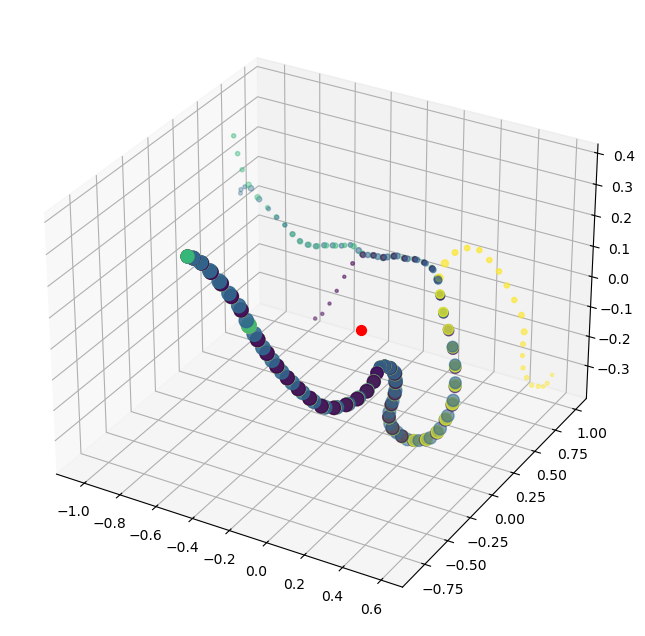

p torch.Size([1, 256, 8])


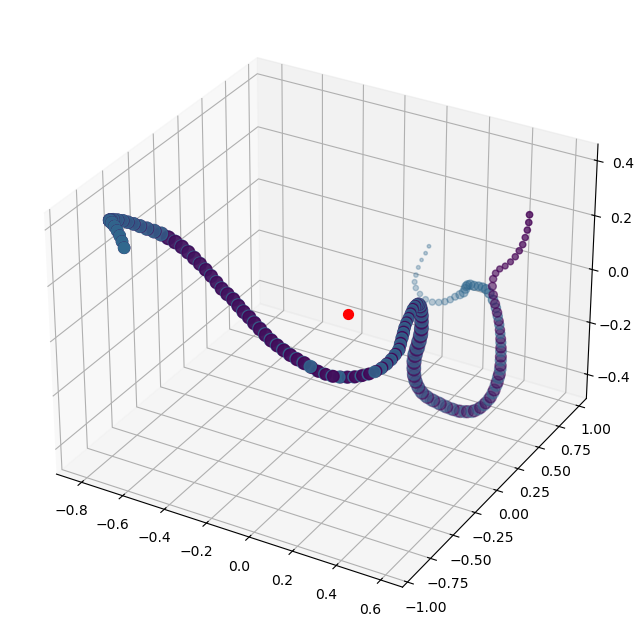

p torch.Size([1, 256, 8])


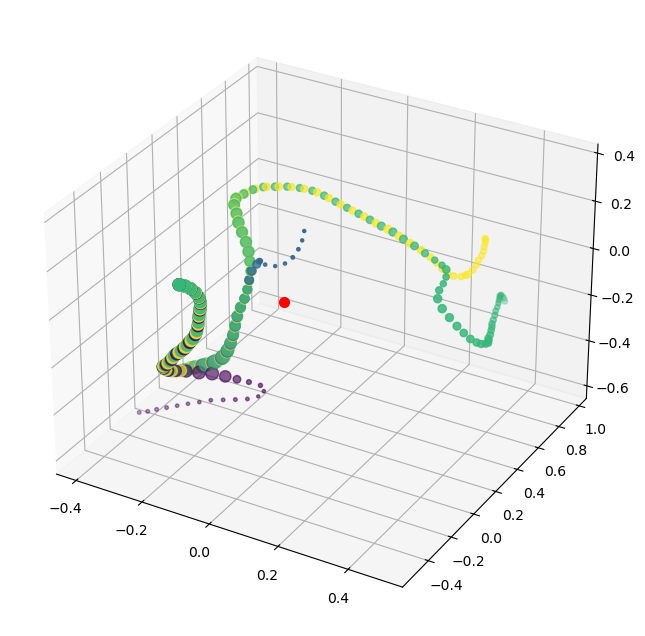

p torch.Size([1, 256, 8])


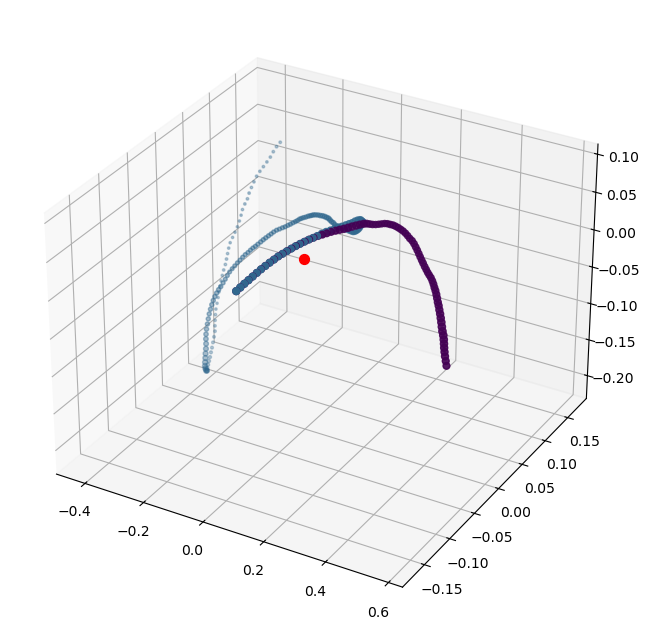

p torch.Size([1, 256, 8])


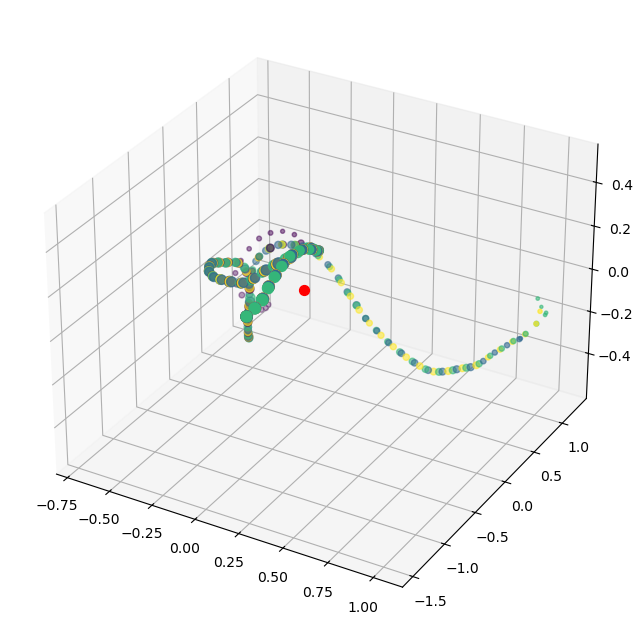

p torch.Size([1, 256, 8])


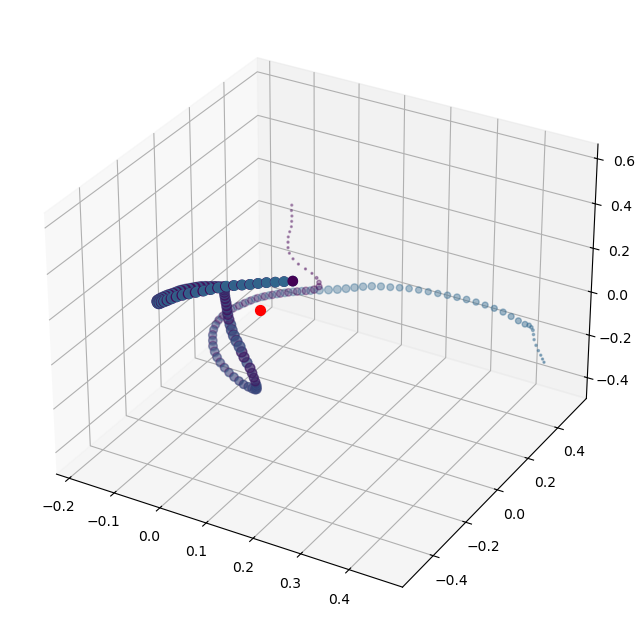

In [12]:
train_set = AneuriskVesselSet(split="train", path="aneurisk")

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=1,
    num_workers=0,
    drop_last=True,
    shuffle=False,
)

for i, (inputs, labels) in enumerate(train_loader):
    print("p", inputs.shape)

    points, radii, types = inputs[:, :, :3], inputs[:, :, 3], inputs[:, :, 4:]
    
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(projection="3d")
    #ax.scatter(*points.T, s=(220 * radii) ** 2, c=types.argmax(-1), vmin=0, vmax=3)
    ax.scatter(*points.T, s=(100 * radii) ** 2, c=types.argmax(-1), vmin=0, vmax=3)
    ax.scatter(0, 0, 0, color='red', s=50, label="Origin")
    
    #ax.set_xlim(-1, 1)
    #ax.set_ylim(-1, 1)
    #ax.set_zlim(-1, 1)

    plt.show()
    if i > 4:
        break

In [8]:
train_set = VesselSet(split="train", path="aneurisk")

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=1,
    num_workers=0,
    drop_last=True,
    shuffle=False,
)

for i, inputs in enumerate(train_loader):
    print(inputs[0].shape)
    #if i > 1:
    #    break

torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 256, 8])
torch.Size([1, 2

In [6]:
pbar = tqdm(train_loader)
len(train_loader)
for inputs, labels in pbar:
    print(inputs.shape)

100%|██████████| 5/5 [00:00<00:00, 34.10it/s]

torch.Size([16, 256, 8])
torch.Size([16, 256, 8])
torch.Size([16, 256, 8])
torch.Size([16, 256, 8])
torch.Size([16, 256, 8])
